In [33]:
# Importarea bibliotecilor necesare
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


### Încărcarea dataset-ului

In [34]:
file_path = 'datasets/Database.csv'
data = pd.read_csv(file_path)


## 🔥 DROP coloane inutile

In [35]:
columns_to_drop = [
    'Author', 'Country', 'State', 'Location', 'Reference', 'Title', 'Study ID', 'Harvest year', 'Journal', 'Year'
    # NU eliminăm 'Latitude', 'Longitude', 'Sowing date', 'Harvest date', 'Soil pH'
]
existing_cols_to_drop = [col for col in columns_to_drop if col in data.columns]
print(data.columns)
data.drop(columns=existing_cols_to_drop, inplace=True)


Index(['Author', 'Journal', 'Year', 'Site country', 'Location', 'Latitude',
       'Longitude', 'Soil information recorded in the paper',
       'pH (surface layer)', 'Replications in experiment', 'Crop',
       'Initial year of NT practice ( or first year of experiment if missing)',
       'Sowing year', 'Harvest year', 'Years since NT started (yrs)',
       'Crop growing season recorded in the paper',
       'Crop rotation with at least 3 crops involved in CT',
       'Crop rotation with at least 3 crops involved in NT',
       'Crop sequence (details)', 'Cover crop before sowing',
       'Soil cover in CT', 'Soil cover in NT',
       'Residue management of previous crop in CT  (details)',
       'Residue management of previous crop in NT (details)',
       'Weed and pest control CT', 'Weed and pest control NT ',
       'Weed and pest control CT (details)',
       'Weed and pest control NT  (details)', 'Fertilization CT ',
       'Fertilization NT', 'N input',
       'N input rates w

## 1. Identificarea valorilor lipsă și completarea lor

In [36]:
# Identificarea coloanelor numerice și categorice
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Convertirea coloanei 'Year' la valori numerice cu validare
year_column = 'Year'
if year_column in data.columns:
    data[year_column] = data[year_column].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Convertirea coloanei 'pH (surface layer)' la valori numerice
ph_column = 'pH (surface layer)'
if ph_column in data.columns:
    data[ph_column] = data[ph_column].replace(' ', np.nan).str.extract(r'(\d+\.?\d*)').astype(float)

# Convertirea coloanei 'Replications in experiment' la valori numerice
replications_column = 'Replications in experiment'
if replications_column in data.columns:
    data[replications_column] = data[replications_column].str.extract(r'(\d+)').astype(float)

# Completarea valorilor lipsă pentru coloanele numerice (cu media)
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Completarea valorilor lipsă pentru coloanele categorice (cu valoarea cea mai frecventă)
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])


## 2. Procesarea coloanei 'Crop sequence (details)'

In [37]:
crop_sequence_column = 'Crop sequence (details)'
if crop_sequence_column in data.columns:
    data[crop_sequence_column] = data[crop_sequence_column].apply(lambda x: 1 if x == 'continuous' else 0)


## 3. Procesarea coloanelor cu valori 'yes' și 'no'

In [38]:
yes_no_columns = [col for col in categorical_columns if data[col].dropna().isin(['yes', 'no']).all()]
for col in yes_no_columns:
    data[col] = data[col].str.lower().apply(lambda x: 1 if x == 'yes' else 0)


## 4. Transformarea datelor categorice

In [39]:
low_cardinality_cols = [col for col in categorical_columns if data[col].nunique() <= 10 and col not in yes_no_columns]
one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
one_hot_encoded_data = pd.DataFrame(one_hot_encoder.fit_transform(data[low_cardinality_cols]),
                                    columns=one_hot_encoder.get_feature_names_out(low_cardinality_cols))

high_cardinality_cols = [col for col in categorical_columns if col not in low_cardinality_cols + yes_no_columns]
label_encoder = LabelEncoder()
for col in high_cardinality_cols:
    data[col] = label_encoder.fit_transform(data[col])


## 5. Combinarea datelor transformate

In [40]:
data = pd.concat([data.drop(columns=low_cardinality_cols), one_hot_encoded_data], axis=1)


## 6. Calcularea corelației Pearson cu 'Yield of CT' și 'Yield of NT' și selecția automata a caracteristicilor

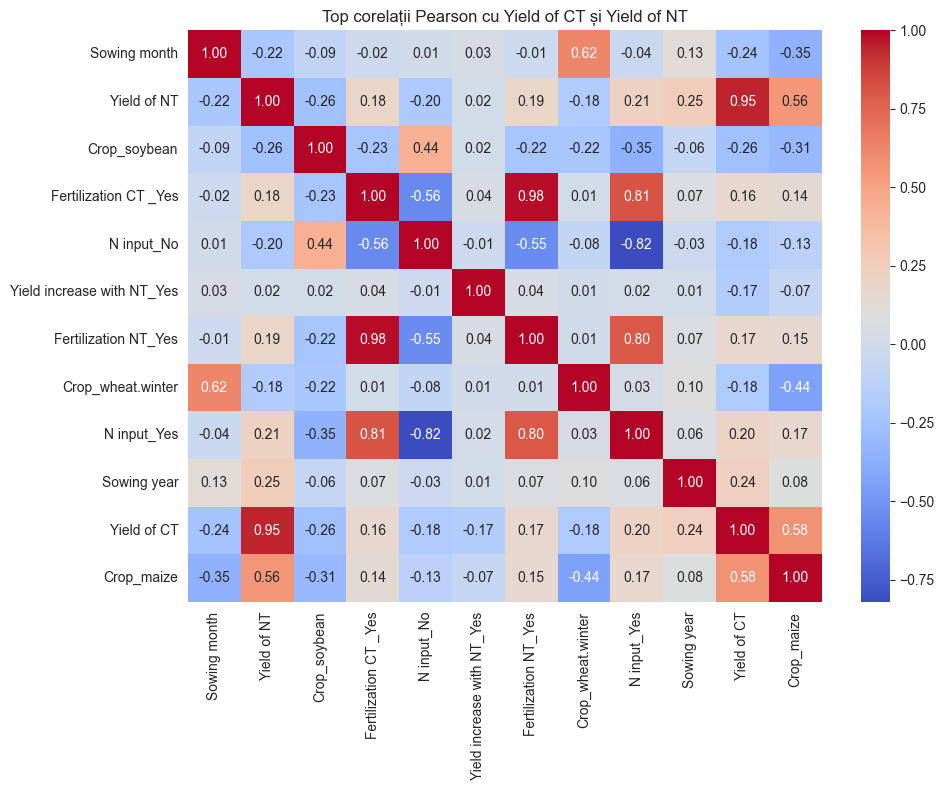

<Figure size 1400x600 with 0 Axes>

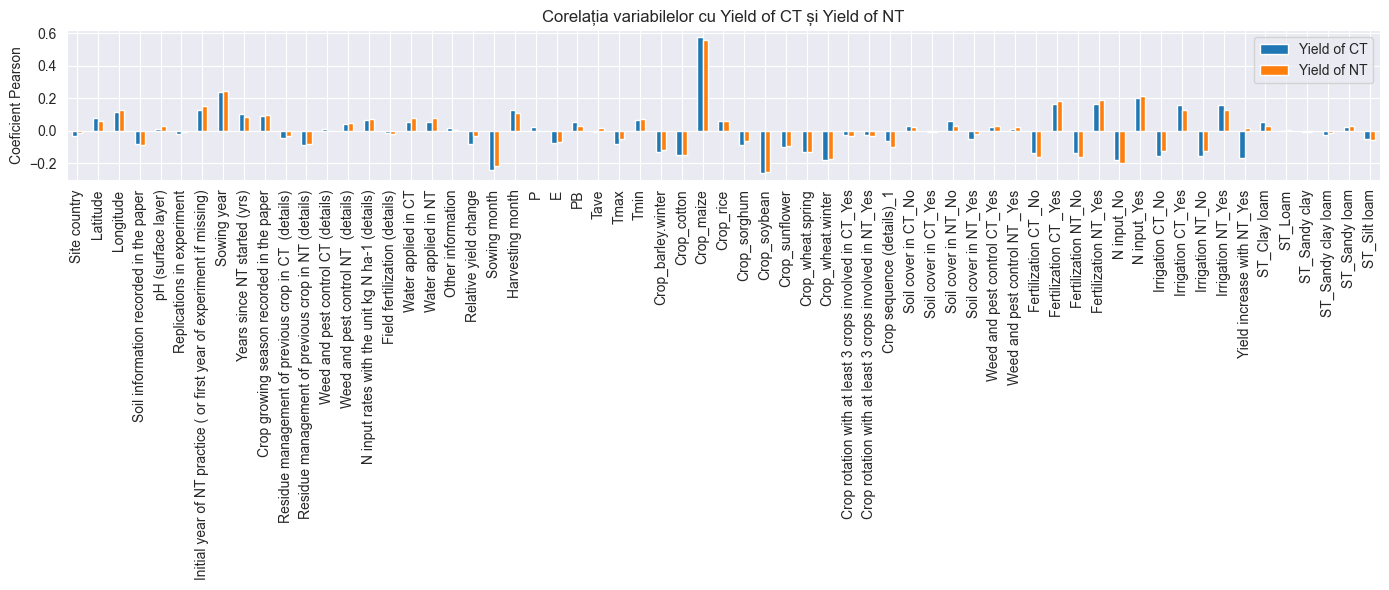

Coloanele selectate automat pe baza corelației Pearson:
['Crop growing season recorded in the paper', 'Crop sequence (details)_1', 'Crop_barley.winter', 'Crop_cotton', 'Crop_maize', 'Crop_rice', 'Crop_sorghum', 'Crop_soybean', 'Crop_sunflower', 'Crop_wheat.spring', 'Crop_wheat.winter', 'E', 'Fertilization CT _No', 'Fertilization CT _Yes', 'Fertilization NT_No', 'Fertilization NT_Yes', 'Harvesting month', 'Initial year of NT practice ( or first year of experiment if missing)', 'Irrigation CT_No', 'Irrigation CT_Yes', 'Irrigation NT_No', 'Irrigation NT_Yes', 'Latitude', 'Longitude', 'N input rates with the unit kg N ha-1 (details)', 'N input_No', 'N input_Yes', 'PB', 'Relative yield change', 'Residue management of previous crop in NT (details)', 'ST_Clay loam', 'ST_Silt loam', 'Soil cover in NT_No', 'Soil cover in NT_Yes', 'Soil information recorded in the paper', 'Sowing month', 'Sowing year', 'Tmax', 'Tmin', 'Water applied in CT', 'Water applied in NT', 'Years since NT started (yrs)', 

In [41]:
yield_columns = ['Yield of CT', 'Yield of NT']
correlation_threshold = 0.05

if all(col in data.columns for col in yield_columns):
    corr_ct = data.corr()['Yield of CT'].drop('Yield of CT')
    corr_nt = data.corr()['Yield of NT'].drop('Yield of NT')

    # Păstrăm doar coloanele cu corelație suficient de puternică cu cel puțin una dintre ține
    relevant_features = corr_ct[abs(corr_ct) >= correlation_threshold].index.union(
                        corr_nt[abs(corr_nt) >= correlation_threshold].index)

    # Adăugăm și coloanele țintă pentru a le păstra
    relevant_features = relevant_features.union(yield_columns)

    # Plot 1: Heatmap doar pentru cele mai relevante 10 caracteristici
    top_ct = corr_ct.abs().sort_values(ascending=False).head(10).index.tolist()
    top_nt = corr_nt.abs().sort_values(ascending=False).head(10).index.tolist()
    top_features = list(set(top_ct + top_nt + yield_columns))

    plt.figure(figsize=(10, 8))
    sns.heatmap(data[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Top corelații Pearson cu Yield of CT și Yield of NT')
    plt.tight_layout()
    plt.show()

    # Plot 2: Bar chart pentru toate variabilele vs. Yield of CT și NT
    plt.figure(figsize=(14, 6))
    corr_all = data.corr()
    corr_with_yields = corr_all[['Yield of CT', 'Yield of NT']].drop(index=yield_columns)
    corr_with_yields.plot(kind='bar', figsize=(14, 6))
    plt.title('Corelația variabilelor cu Yield of CT și Yield of NT')
    plt.ylabel('Coeficient Pearson')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    data = data[relevant_features]

    print("Coloanele selectate automat pe baza corelației Pearson:")
    print(relevant_features.tolist())
else:
    print("Una sau ambele coloane ('Yield of CT', 'Yield of NT') nu sunt prezente pentru corelație.")


## 7. Salvarea dataset-ului procesat

In [42]:
print("\nPreview set de date procesat:")
print(data.head())

processed_file_path = '/Users/robertochiper/PycharmProjects/SmartAgriculture_iteratia1/datasets/Processed_Database.csv'
data.to_csv(processed_file_path, index=False)
print(f"Fișierul procesat a fost salvat la: {processed_file_path}")


Preview set de date procesat:
   Crop growing season recorded in the paper  Crop sequence (details)_1  \
0                                         73                        1.0   
1                                         73                        1.0   
2                                         73                        1.0   
3                                         56                        0.0   
4                                         80                        0.0   

   Crop_barley.winter  Crop_cotton  Crop_maize  Crop_rice  Crop_sorghum  \
0                 0.0          0.0         0.0        0.0           0.0   
1                 0.0          0.0         0.0        0.0           0.0   
2                 0.0          0.0         0.0        0.0           0.0   
3                 0.0          0.0         0.0        0.0           0.0   
4                 0.0          0.0         0.0        0.0           0.0   

   Crop_soybean  Crop_sunflower  Crop_wheat.spring  ...  Sowing mon